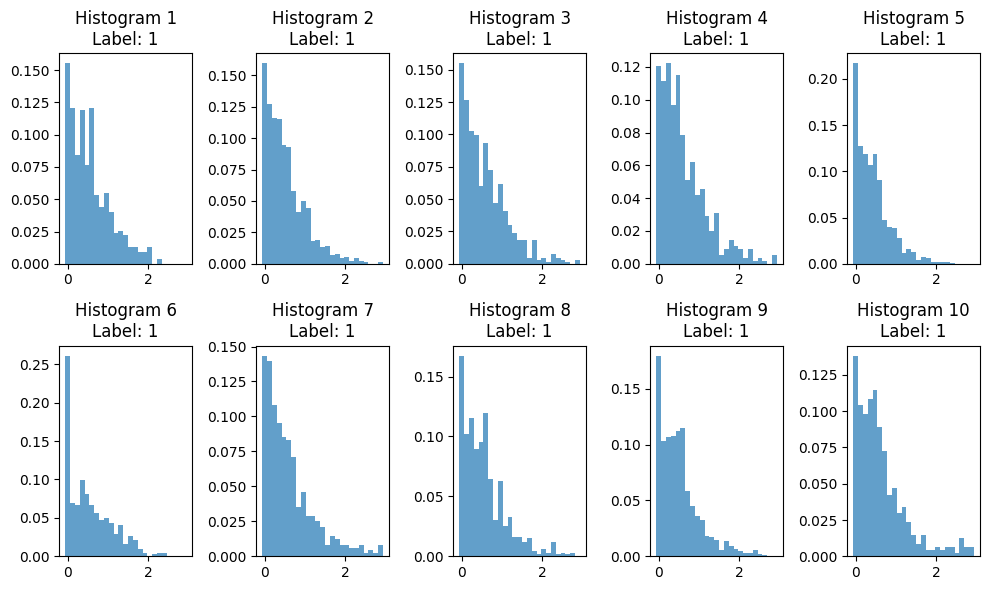

In [48]:
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
data = np.load('hist.npz')
histograms = data['data']
labels = data['labels']
binspec = data['binspec']

# Visualize some histograms
def plot_histograms(histograms, labels, binspec, num=10):
    plt.figure(figsize=(10, 6))
    for i in range(num):
        plt.subplot(2, 5, i+1)
        plt.bar(binspec[:-1], histograms[i], width=binspec[1]-binspec[0], alpha=0.7, label=f'Label {labels[i]}')
        plt.title(f'Histogram {i+1}\nLabel: {labels[i]}')
    plt.tight_layout()
    plt.show()

plot_histograms(histograms, labels, binspec)

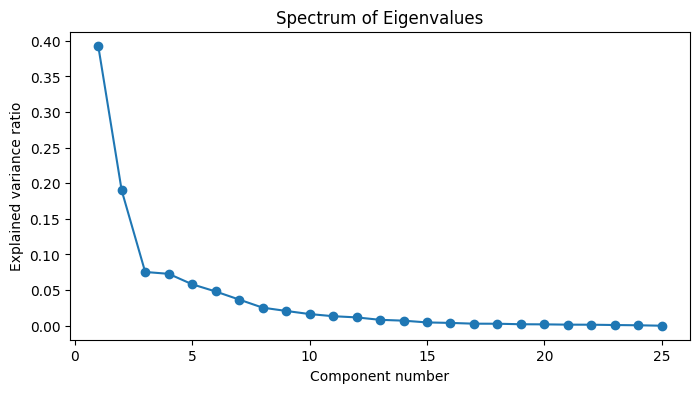

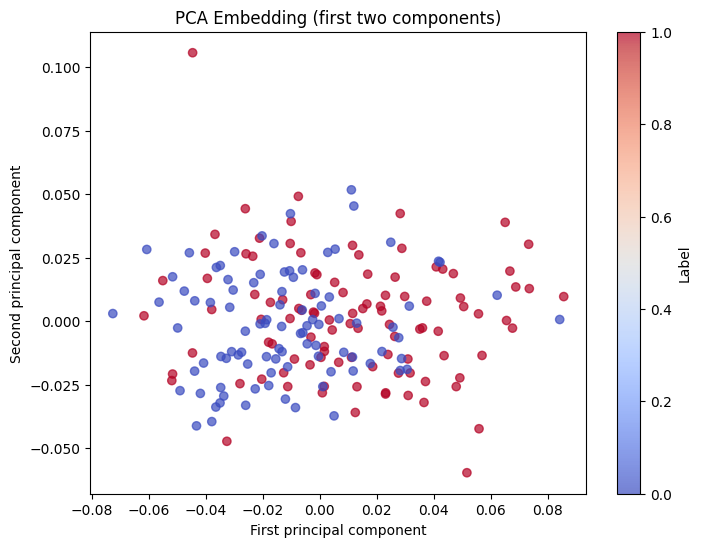

In [49]:
from sklearn.decomposition import PCA

# Apply PCA
pca = PCA()
pca.fit(histograms)
histograms_pca = pca.transform(histograms)

# Plot the spectrum of eigenvalues
plt.figure(figsize=(8, 4))
plt.plot(np.arange(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_, marker='o')
plt.title('Spectrum of Eigenvalues')
plt.xlabel('Component number')
plt.ylabel('Explained variance ratio')
plt.show()

# Plot the embedding on the first two eigenvectors
plt.figure(figsize=(8, 6))
scatter = plt.scatter(histograms_pca[:, 0], histograms_pca[:, 1], c=labels, cmap='coolwarm', alpha=0.7)
plt.colorbar(scatter, label='Label')
plt.title('PCA Embedding (first two components)')
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.show()


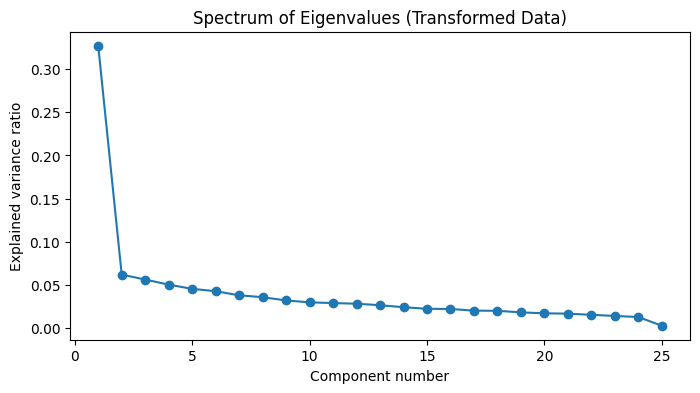

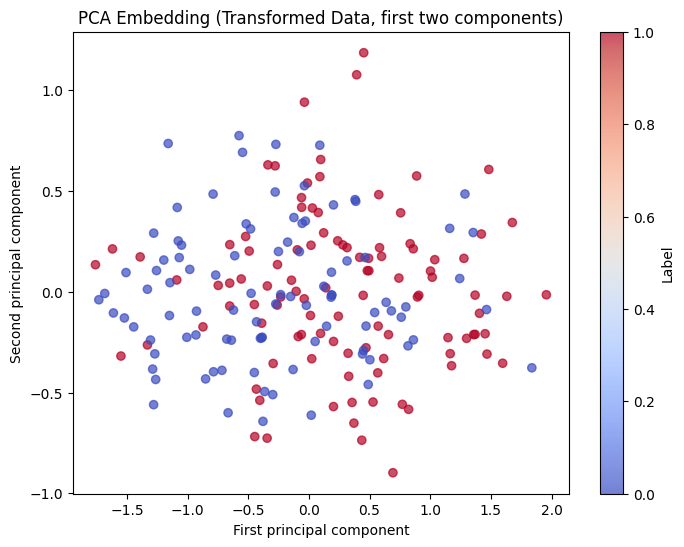

In [57]:
from scipy.stats import rankdata

# Apply the inverse cumulative distribution transform
def inverse_cumulative_transform(data):
    transformed_data = np.zeros_like(data)
    for i in range(data.shape[1]):
        ranks = rankdata(data[:, i], method='average')
        transformed_data[:, i] = (ranks - 1) / (len(ranks) - 1)
    return transformed_data

histograms_transformed = inverse_cumulative_transform(histograms)

# Apply PCA to the transformed data
pca_transformed = PCA()
pca_transformed.fit(histograms_transformed)
histograms_pca_transformed = pca_transformed.transform(histograms_transformed)

# Plot the spectrum of eigenvalues for the transformed data
plt.figure(figsize=(8, 4))
plt.plot(np.arange(1, len(pca_transformed.explained_variance_ratio_)+1), pca_transformed.explained_variance_ratio_, marker='o')
plt.title('Spectrum of Eigenvalues (Transformed Data)')
plt.xlabel('Component number')
plt.ylabel('Explained variance ratio')
plt.show()

# Plot the embedding on the first two eigenvectors for the transformed data
plt.figure(figsize=(8, 6))
scatter_transformed = plt.scatter(histograms_pca_transformed[:, 0], histograms_pca_transformed[:, 1], c=labels, cmap='coolwarm', alpha=0.7)
plt.colorbar(scatter_transformed, label='Label')
plt.title('PCA Embedding (Transformed Data, first two components)')
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.show()

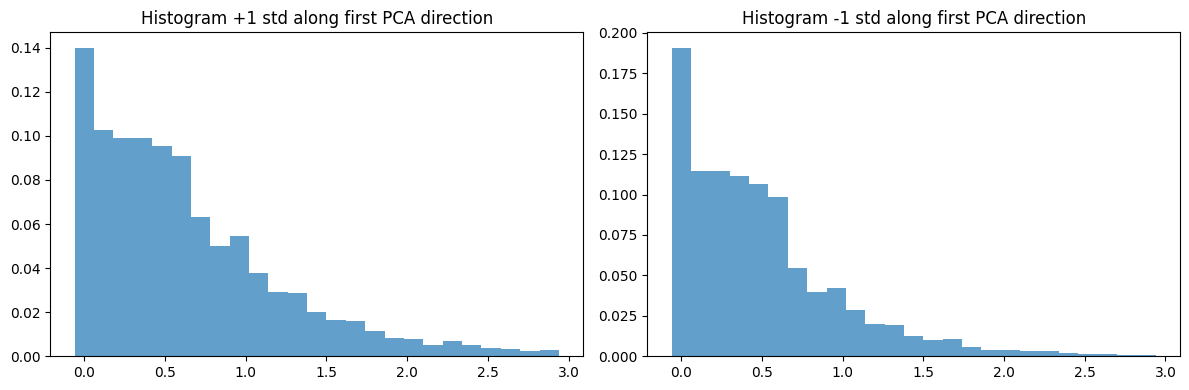

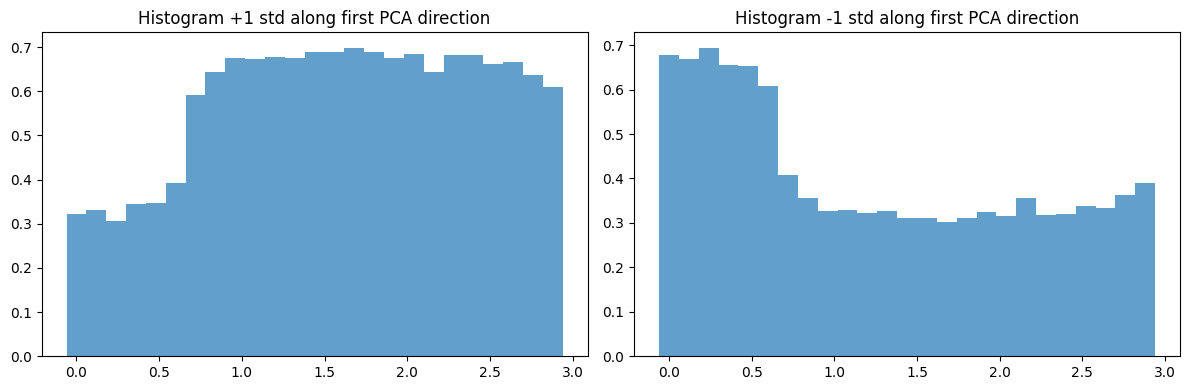

In [58]:
def visualize_pca_change(pca, histograms, binspec, direction=0):
    mean_histogram = pca.mean_
    std_dev = np.sqrt(pca.explained_variance_[direction])
    direction_vector = pca.components_[direction]

    # Compute histograms along the first PCA direction
    histograms_plus = mean_histogram + std_dev * direction_vector
    histograms_minus = mean_histogram - std_dev * direction_vector

    # Plot the histograms
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.bar(binspec[:-1], histograms_plus, width=binspec[1]-binspec[0], alpha=0.7)
    plt.title('Histogram +1 std along first PCA direction')

    plt.subplot(1, 2, 2)
    plt.bar(binspec[:-1], histograms_minus, width=binspec[1]-binspec[0], alpha=0.7)
    plt.title('Histogram -1 std along first PCA direction')

    plt.tight_layout()
    plt.show()

# Visualize for original data
visualize_pca_change(pca, histograms, binspec)

# Visualize for transformed data
visualize_pca_change(pca_transformed, histograms_transformed, binspec)

In [59]:
import glob
import imageio.v3 as iio
import re
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
# Define the path to the images
image_path = 'imgs/sandal_e*_a*.png'

# Use glob to get all filenames
image_files = glob.glob(image_path)

# Check if image_files is not empty
if not image_files:
    raise ValueError("No images found. Please check the image path.")

# Initialize lists to store images and their corresponding parameters
images = []
elevations = []
azimuths = []

# Regular expression to extract elevation and azimuth from filenames
pattern = re.compile(r'sandal_e(\d+)_a(\d+)\.png')

for file in image_files:
    # Read the image
    img = iio.imread(file)  # Read image as grayscale
    images.append(img)
    
    # Extract elevation and azimuth from filename
    match = pattern.search(file)
    if match:
        elevation = int(match.group(1))
        azimuth = int(match.group(2))
        elevations.append(elevation)
        azimuths.append(azimuth)
    else:
        print(f"Filename does not match pattern: {file}")

# Convert lists to numpy arrays
images = np.array(images)
elevations = np.array(elevations)
azimuths = np.array(azimuths)

# Check if elevations and azimuths are not empty
if elevations.size == 0 or azimuths.size == 0:
    raise ValueError("Elevation and/or azimuth arrays are empty. Check the regular expression and filenames.")

# Check the range of elevation and azimuth values
print("Elevation range:", elevations.min(), "-", elevations.max())
print("Azimuth range:", azimuths.min(), "-", azimuths.max())


Elevation range: 20 - 59
Azimuth range: 0 - 87


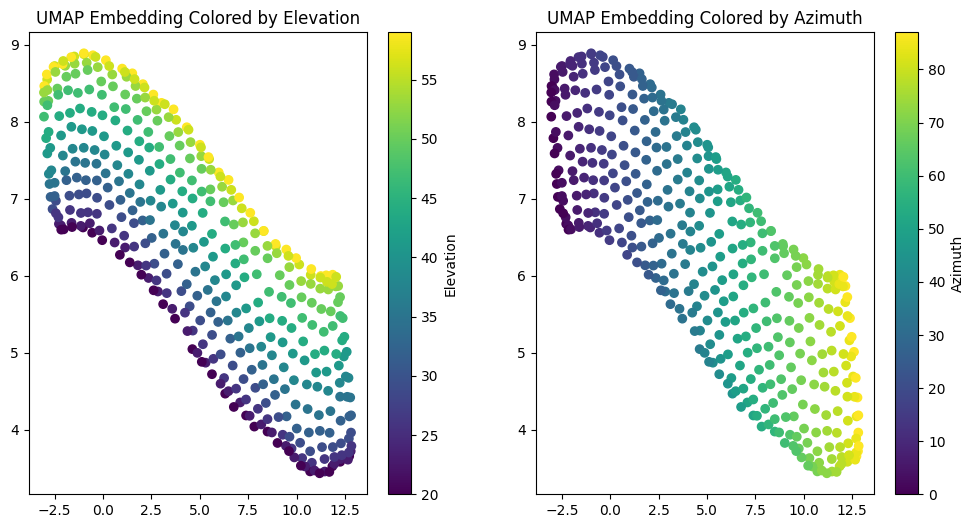

In [52]:
import umap.umap_ as umap

# Flatten the images
images_flattened = images.reshape(images.shape[0], -1)

# Apply UMAP
umap_model = umap.UMAP(n_components=2)
embedding = umap_model.fit_transform(images_flattened)

# Plot the embedding with elevation and azimuth as visual attributes
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=elevations, cmap='viridis')
plt.colorbar(scatter, label='Elevation')
plt.title('UMAP Embedding Colored by Elevation')

plt.subplot(1, 2, 2)
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=azimuths, cmap='viridis')
plt.colorbar(scatter, label='Azimuth')
plt.title('UMAP Embedding Colored by Azimuth')

plt.show()

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


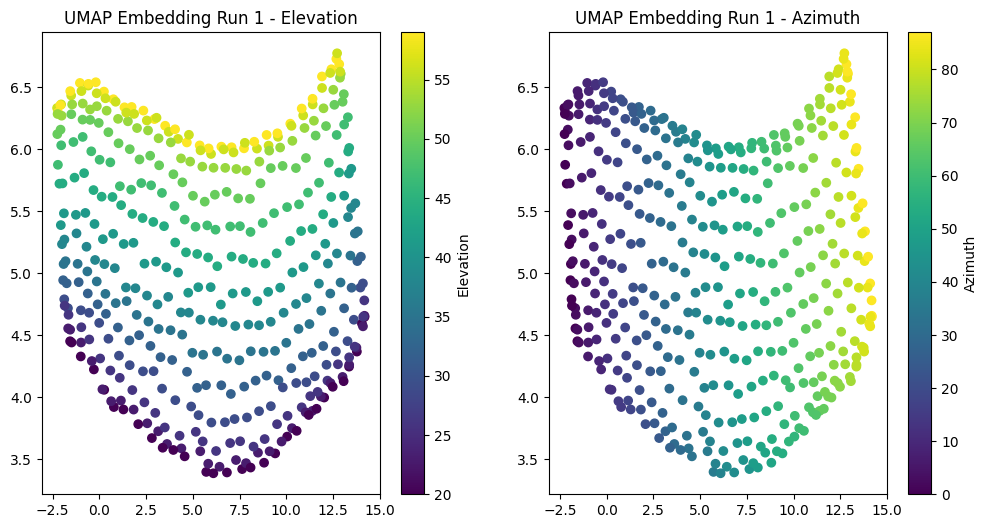

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


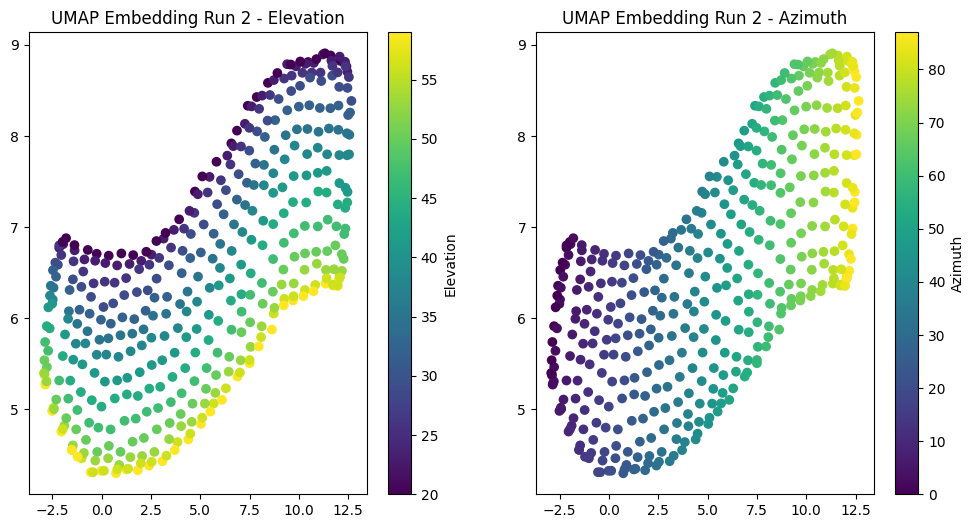

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


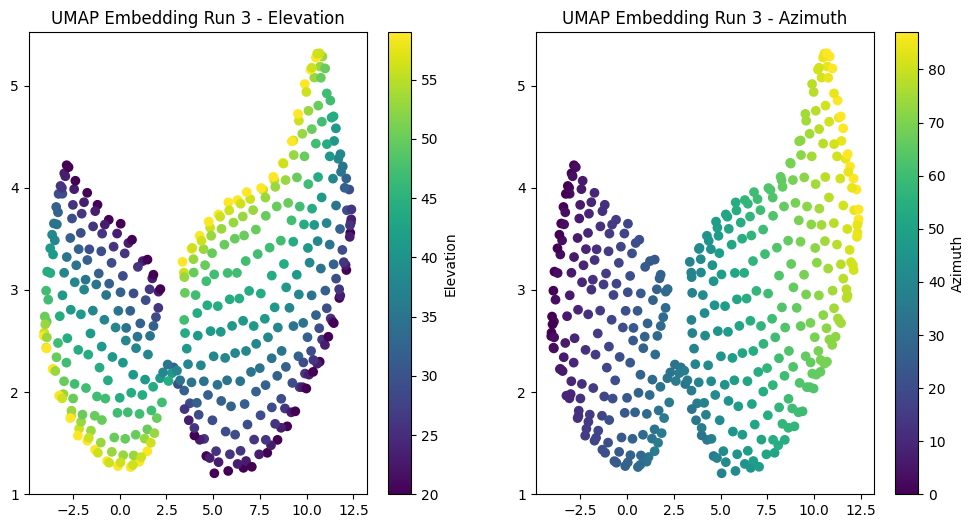

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


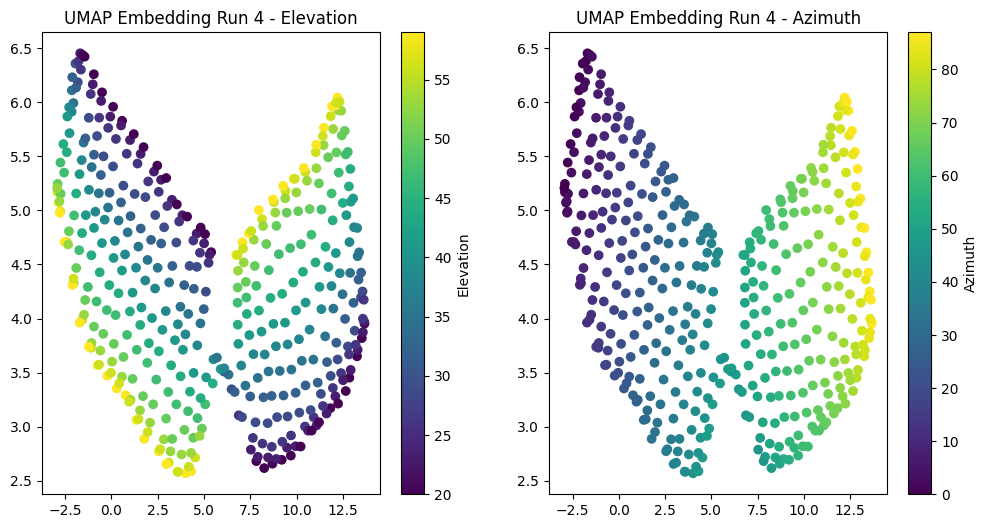

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


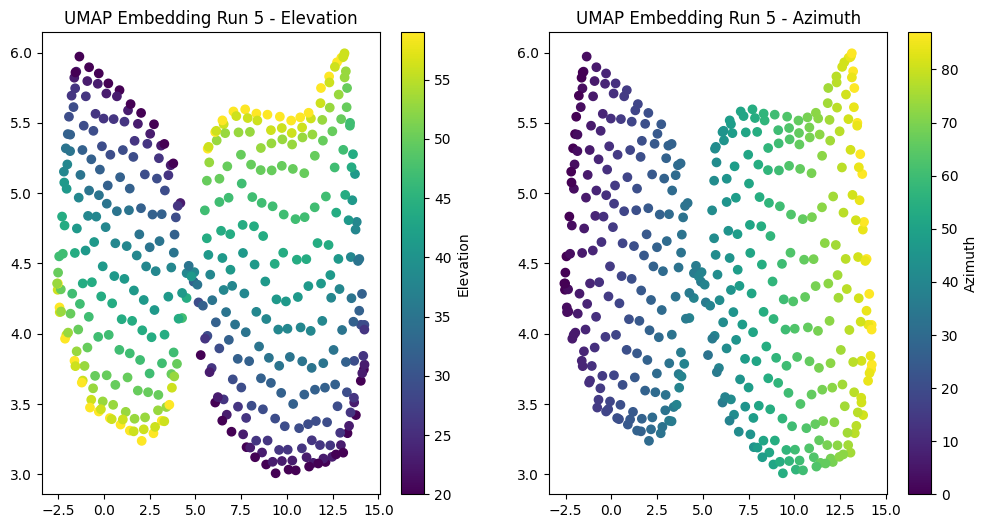

In [39]:
for i in range(5):
    umap_model = umap.UMAP(n_components=2, random_state=i)
    embedding = umap_model.fit_transform(images_flattened)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=elevations, cmap='viridis')
    plt.colorbar(scatter, label='Elevation')
    plt.title(f'UMAP Embedding Run {i+1} - Elevation')

    plt.subplot(1, 2, 2)
    scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=azimuths, cmap='viridis')
    plt.colorbar(scatter, label='Azimuth')
    plt.title(f'UMAP Embedding Run {i+1} - Azimuth')

    plt.show()


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


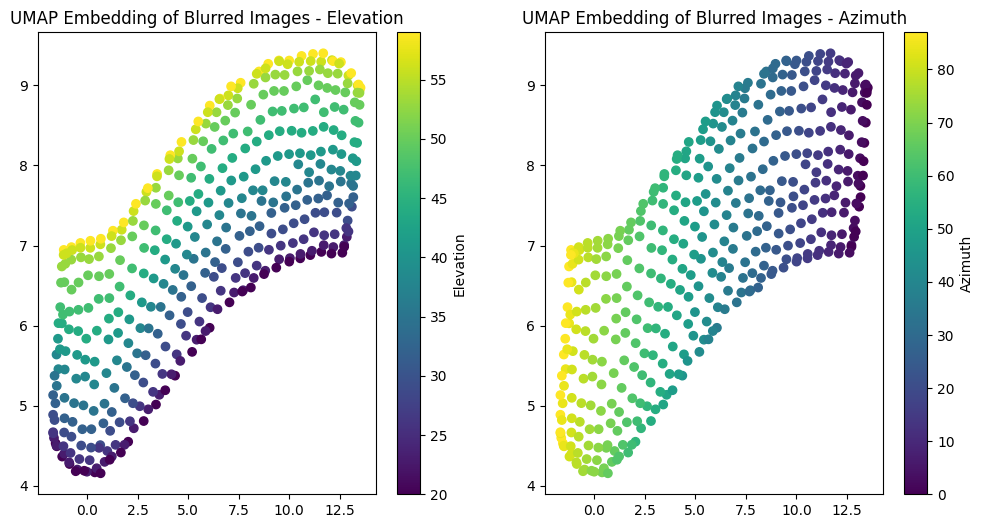

In [53]:
from scipy.signal import convolve2d

# Define the blur kernel
kernel = np.array([[1/16, 1/8, 1/16],
                   [1/8, 1/4, 1/8],
                   [1/16, 1/8, 1/16]])

# Apply the blur convolution to each image
images_blurred = np.array([convolve2d(img, kernel, mode="valid") for img in images])

# Flatten the blurred images
images_blurred_flattened = images_blurred.reshape(images_blurred.shape[0], -1)

# Apply UMAP to the blurred images
umap_model_blurred = umap.UMAP(n_components=2, random_state=42)
embedding_blurred = umap_model_blurred.fit_transform(images_blurred_flattened)

# Plot the embedding with elevation and azimuth as visual attributes
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
scatter = plt.scatter(embedding_blurred[:, 0], embedding_blurred[:, 1], c=elevations, cmap='viridis')
plt.colorbar(scatter, label='Elevation')
plt.title('UMAP Embedding of Blurred Images - Elevation')

plt.subplot(1, 2, 2)
scatter = plt.scatter(embedding_blurred[:, 0], embedding_blurred[:, 1], c=azimuths, cmap='viridis')
plt.colorbar(scatter, label='Azimuth')
plt.title('UMAP Embedding of Blurred Images - Azimuth')

plt.show()
